In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
from torch import nn
import torch.optim as opt
from scipy import signal
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import imageio
#import torch
#print(torch.__file__,torch.__version__)

In [ ]:
def create_football_field(imgSize=(12.66, 24),
                          playerCoordinatesProvided=False,
                          playerCoordinates=[],
                          labelNumbers=True,
                          showArrow=True,
                          fieldColor='gray',
                          endZoneColor='yellow',
                          first_down=False,
                          number_of_yards_left=False,
                          g = [],p = []
                          ):
  rect = patches.Rectangle((0, 0), 53.3, 120, linewidth=0.1,
                             edgecolor='r', facecolor=fieldColor, zorder=0) #Creates the rectangle of coordinates for the field
  fig, ax = plt.subplots(1, figsize=imgSize)
  plt.plot([0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3,
              53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 53.3, 0, 0, 53.3],
           [10, 10, 10, 20, 20, 30, 30, 40, 40, 50, 50, 60, 60, 70, 70, 80,
              80, 90, 90, 100, 100, 110, 110, 120, 0, 0, 120, 120],
             color='white') # plots the location of the field lines
  homeEndzone = patches.Rectangle((0, 0), 53.3, 10,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor=endZoneColor,
                                alpha=0.2,
                                zorder=10) #Plots the endzone for the home team
  awayEndzone = patches.Rectangle((0, 110), 53.3, 10,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor=endZoneColor,
                                alpha=0.2,
                                zorder=10) #Plots the endzone for the away team
  ax.add_patch(homeEndzone)
  ax.add_patch(awayEndzone)
  for y in range(20, 110, 10): #Adds the field marker numbers
            numb = y
            if y > 50:
                numb = 120 - y
            plt.text(5, y-1.5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white', rotation=270)
            plt.text(53.3 - 5, y - 0.95, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white', rotation=90) #
  for y in range(11,110): #Adds all of the  hash lines
        ax.plot([0.7, 0.4],[y, y], color='white')
        ax.plot([53.0, 52.5],[y, y], color='white')
        ax.plot([22.91, 23.57],[y, y], color='white')
        ax.plot([29.73, 30.39],[y, y],  color='white')
  if playerCoordinatesProvided: #Plots player coordinates
    carrierId = plays[(plays['gameId'] == g) & (plays['playId'] == p)]["ballCarrierId"].iloc[0]
    team1 = plays[(plays['gameId'] == g) & (plays['playId'] == p) ]['possessionTeam'].iloc[0]
    for index, row in playerCoordinates.iterrows():
      
      if row['nflId']==carrierId:
        plt.scatter(row['y'],row['x'], color='pink', s=300)
      elif row['club'] == 'football':
        plt.scatter(row['y'],row['x'], color='brown', s=100)
      elif row['club']==team1:
        plt.scatter(row['y'],row['x'], color= 'red', s=300) #Given color red if home team, blue if away
        if showArrow==True:
          plt.arrow(row['y'],row['x'],row['xspeed'], row['yspeed']*0.1, color='green',width = 0.1) #if user wants direction arrow
        if labelNumbers:
          plt.annotate(int(row['jerseyNumber']), (row['y'], row['x']),xytext=(row['y']-0.5, row['x']-0.5), color='white') #if user wants jersey numbers
      else:
        plt.scatter(row['y'],row['x'], color = 'blue', s=300)
        if showArrow==True:
          plt.arrow(row['y'],row['x'],row['xspeed'], row['yspeed']*0.1, color='orange', width = 0.1)
        if labelNumbers:
          plt.annotate(int(row['jerseyNumber']), (row['y'], row['x']),xytext=(row['y']-0.5, row['x']-0.5), color='white')

  if first_down==True:
    plt.plot([0,53.3], [10+float(playerCoordinates.iloc[0]['yardlineNumber']), 10+float(playerCoordinates.iloc[0]['yardlineNumber'])], color='blue')
    plt.plot([0,53.3], [10+float(playerCoordinates.iloc[0]['yardlineNumber'])+float(playerCoordinates.iloc[0]['yardsToGo']), 10+float(playerCoordinates.iloc[0]['yardlineNumber'])+float(playerCoordinates.iloc[0]['yardsToGo'])], color='yellow')

  if number_of_yards_left==True:
    ball_carrier_x = float(playerCoordinates.loc[playerCoordinates['nflId']==playerCoordinates['ballCarrierId']].iloc[0]['x'])
    yards= float(playerCoordinates.loc[playerCoordinates['nflId']==playerCoordinates['ballCarrierId']].iloc[0]['playResult'])
    starting_point=float(10+float(playerCoordinates.iloc[0]['yardlineNumber']))
    num_yards=yards+starting_point-ball_carrier_x
    plt.text(14, 3, f"Number of Yards Left: {num_yards:.2f}", color='red', fontsize=30)

  ax.add_patch(rect)
  plt.ylim(0, 120)
  plt.xlim(-5, 58.3)
  plt.axis('off')

def processToVisualize(tracking, play, game_info, gameId, playId, time):
  tracking_single=tracking.loc[(tracking['playId'] == playId) & (tracking['frameId']==time) & (tracking['gameId']==gameId)]
  testingNew=pd.merge(tracking_single, play, on=['gameId', 'playId'], how='inner')
  testingNew=pd.merge(testingNew, game_info, on=['gameId'], how='inner')
  testingNew['radiansDirection'] = testingNew['dir'].astype(float).apply(math.radians) #Converts angle in degrees to radians
  testingNew['xComponent']=testingNew['radiansDirection'].astype(float).apply(math.cos) #Converts angle into an x and y component
  testingNew['yComponent']=testingNew['radiansDirection'].astype(float).apply(math.sin)
  testingNew['xspeed']=testingNew['xComponent']*testingNew['s'] #Determines magnitude of speed by multiplying x and y component by magnitude of speed
  testingNew['yspeed']=testingNew['yComponent']*testingNew['s']
  return testingNew

#create_football_field()
season = 2024
filename = os.path.join(os.path.join("Data", str(season)),"plays.csv")
plays = pd.read_csv(filename)
filename = os.path.join(os.path.join("Data", str(season)),"games.csv")
games = pd.read_csv(filename)
i = 1
filename = os.path.join(os.path.join("Data", str(season)),"tracking_week_"+str(i) +".csv")
#print(filename)
week1 = pd.read_csv(filename)
single_play=processToVisualize(week1, plays, games, 2022090800, 56, 14)
create_football_field(playerCoordinatesProvided=True,playerCoordinates=single_play, labelNumbers=True ,showArrow=True, fieldColor='green', endZoneColor='blue', first_down=True, number_of_yards_left=True, g = 2022090800, p = 56)
print(max(week1['frameId']))


In [2]:
class AttentionBlock(nn.Module):
    def __init__(self, in_features_l, in_features_g, attn_features, up_factor, normalize_attn=True):
        super(AttentionBlock, self).__init__()
        self.up_factor = up_factor
        self.normalize_attn = normalize_attn
        self.W_l = nn.Conv2d(in_channels=in_features_l, out_channels=attn_features, kernel_size=1, padding=0, bias=False)
        self.W_g = nn.Conv2d(in_channels=in_features_g, out_channels=attn_features, kernel_size=1, padding=0, bias=False)
        self.phi = nn.Conv2d(in_channels=attn_features, out_channels=1, kernel_size=1, padding=0, bias=True)
        self.relu = nn.SiLU()
    def forward(self, l, g):
        #print(in_features_g)
        N, C, W, H = l.shape
        l_ = self.W_l(l)
        g_ = self.W_g(g)
        #print(g_.shape)
        c = self.phi(self.relu(l_ + g_)) # batch_sizex1xWxH
        #print(c.shape)
        # compute attn map
        if self.normalize_attn:
            a = (c.view(N,1,-1)).view(N,1,W,H)
        else:
            a = torch.sigmoid(c)
        # re-weight the local feature
        f = torch.mul(a.expand_as(l), l) # batch_sizexCxWxH
        if self.normalize_attn:
            output = f.view(N,C,-1) # weighted sum
        else:
            output = nn.AdaptiveAvgPool2d(f, (1,1)).view(N,C) # global average pooling
        return a, output

class Skynet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv21 = nn.Conv2d(8,128,1,stride = 1)
        self.conv22 = nn.Conv2d(128, 160, 1,stride = 1)
        self.conv23 = nn.Conv2d(160,128, 1,stride = 1)
        self.poolmax2 = nn.MaxPool2d(1,5)
        self.poolavg2 = nn.AvgPool2d(1,5)

        self.poolmax1 = nn.MaxPool1d(1,5)
        self.poolavg1 = nn.AvgPool1d(1,5)
        self.batch1 = nn.BatchNorm1d(2)

        self.conv11 = nn.Conv1d(2,128,1)
        self.batch2 = nn.BatchNorm1d(128)
        self.conv12 = nn.Conv1d(128,160,1)
        self.batch3 = nn.BatchNorm1d(160)
        self.conv13 = nn.Conv1d(160,96,1)
        self.batch4 = nn.BatchNorm1d(96)

        self.attentionmech = AttentionBlock(8, 128, 256, 4, normalize_attn=True)
        self.fc1 = nn.Linear(2112,512)
        self.fc2 = nn.Linear(512,256)
        self.batch6 = nn.BatchNorm1d(512)
        self.batch5 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256,1)
        #self.squeeze = torch.squeeze(1)
        self.relu = nn.SiLU()

    def forward(self,x):
        temp = x
        x = self.relu(self.conv21(x))
        x = self.relu(self.conv22(x))
        x = self.relu(self.conv23(x))
        attention, x = self.attentionmech(temp,x)
        xmax = self.poolmax2(x)
        xavg = self.poolavg2(x)
        x = 0.3*xmax + 0.7*xavg
        #print(x.shape)
        
        #x = torch.flatten(x,start_dim=2,end_dim=3)
        x = self.batch1(x)
        x = self.relu(self.conv11(x))
        x = self.batch2(x)
        x = self.relu(self.conv12(x))
        x = self.batch3(x)
        x = self.relu(self.conv13(x))
        x = self.batch4(x)
        xmax = self.poolmax1(x)
        xavg = self.poolavg1(x)
        x = 0.3*xmax + 0.7*xavg
        x = torch.flatten(x,start_dim=1,end_dim=2)
        #print(x.shape)

        x = self.relu(self.fc1(x))
        #print(x.mT.shape)
        x = self.batch6(x)
        x = self.relu(self.fc2(x))
        #x = self.batch5(x.T)
        x = self.fc3(x)
        return x, attention
    
class Skynet2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv21 = nn.Conv2d(128,128,1,stride = 1)
        self.conv22 = nn.Conv2d(128, 256, 1,stride = 1)
        self.conv23 = nn.Conv2d(256,128, 1,stride = 1)
        self.conv24 = nn.Conv2d(8,128,1,stride = 1)
        self.conv25 = nn.Conv2d(128, 256, 1,stride = 1)
        self.conv26 = nn.Conv2d(256,128, 1,stride = 1)

        self.dconv21 = nn.Conv2d(8,128,1,stride = 1)
        self.dconv22 = nn.Conv2d(128, 160, 1,stride = 1)
        self.dconv23 = nn.Conv2d(160,128, 1,stride = 1)
        self.oconv21 = nn.Conv2d(8,128,1,stride = 1)
        self.oconv22 = nn.Conv2d(128, 160, 1,stride = 1)
        self.oconv23 = nn.Conv2d(160,128, 1,stride = 1)
        self.poolmax2 = nn.MaxPool2d(1,5)
        self.poolavg2 = nn.AvgPool2d(1,5)

        self.poolmax1 = nn.MaxPool1d(1,5)
        self.poolavg1 = nn.AvgPool1d(1,5)
        self.batch1 = nn.BatchNorm1d(2)

        self.conv11 = nn.Conv1d(2,128,1)
        self.batch2 = nn.BatchNorm1d(128)
        self.conv12 = nn.Conv1d(128,160,1)
        self.batch3 = nn.BatchNorm1d(160)
        self.conv13 = nn.Conv1d(160,96,1)
        self.batch4 = nn.BatchNorm1d(96)

        self.attentionmech = AttentionBlock(8, 128, 256, 4, normalize_attn=True)
        self.fc1 = nn.Linear(2112,512)
        self.fc2 = nn.Linear(512,256)
        self.batch6 = nn.BatchNorm1d(512)
        self.batch5 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256,1)
        #self.squeeze = torch.squeeze(1)
        self.relu = nn.SiLU()

    def forward(self,x):
        temp = x
        dfence = x[:,:,:,:11]
        ofence = x[:,:,:,11:]
        
        dfence = self.relu(self.dconv21(dfence))
        dfence = self.relu(self.dconv22(dfence))
        dfence = self.relu(self.dconv23(dfence))

        ofence = self.relu(self.oconv21(ofence))
        ofence = self.relu(self.oconv22(ofence))
        ofence = self.relu(self.oconv23(ofence))
        '''
        x = self.relu(self.conv24(x))
        x = self.relu(self.conv25(x))
        x = self.relu(self.conv26(x))
        '''
        #print(ofence.shape,dfence.shape)
        #x = 0.5*torch.cat((dfence,ofence),dim = 3) + 0.5*x
        #print(x.shape)
        #print(temp.shape)
        x = torch.cat((dfence,ofence),dim = 3)

        x = self.relu(self.conv21(x))
        x = self.relu(self.conv22(x))
        x = self.relu(self.conv23(x))

        attention, x = self.attentionmech(temp,x)
        xmax = self.poolmax2(x)
        xavg = self.poolavg2(x)
        x = 0.3*xmax + 0.7*xavg
        #print(x.shape)
        
        #x = torch.flatten(x,start_dim=2,end_dim=3)
        x = self.batch1(x)
        x = self.relu(self.conv11(x))
        x = self.batch2(x)
        x = self.relu(self.conv12(x))
        x = self.batch3(x)
        x = self.relu(self.conv13(x))
        x = self.batch4(x)
        xmax = self.poolmax1(x)
        xavg = self.poolavg1(x)
        x = 0.3*xmax + 0.7*xavg
        x = torch.flatten(x,start_dim=1,end_dim=2)
        #print(x.shape)

        x = self.relu(self.fc1(x))
        #print(x.mT.shape)
        x = self.batch6(x)
        x = self.relu(self.fc2(x))
        #x = self.batch5(x.T)
        x = self.fc3(x)
        return x, attention

class Skynet3(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv21 = nn.Conv2d(256,512,1,stride = 1)
        self.conv22 = nn.Conv2d(512, 256, 1,stride = 1)
        self.conv23 = nn.Conv2d(256,128, 1,stride = 1)
        self.conv24 = nn.Conv2d(8,128,1,stride = 1)
        self.conv25 = nn.Conv2d(128, 256, 1,stride = 1)
        self.conv26 = nn.Conv2d(256,128, 1,stride = 1)

        self.dconv21 = nn.Conv2d(8,128,1,stride = 1)
        self.dconv22 = nn.Conv2d(128, 160, 1,stride = 1)
        self.dconv23 = nn.Conv2d(160,128, 1,stride = 1)
        self.oconv21 = nn.Conv2d(8,128,1,stride = 1)
        self.oconv22 = nn.Conv2d(128, 160, 1,stride = 1)
        self.oconv23 = nn.Conv2d(160,128, 1,stride = 1)
        self.poolmax2 = nn.MaxPool2d(1,5)
        self.poolavg2 = nn.AvgPool2d(1,5)

        self.poolmax1 = nn.MaxPool1d(1,5)
        self.poolavg1 = nn.AvgPool1d(1,5)
        self.batch1 = nn.BatchNorm1d(2)

        self.conv11 = nn.Conv1d(2,128,1)
        self.batch2 = nn.BatchNorm1d(128)
        self.conv12 = nn.Conv1d(128,160,1)
        self.batch3 = nn.BatchNorm1d(160)
        self.conv13 = nn.Conv1d(160,96,1)
        self.batch4 = nn.BatchNorm1d(96)

        self.attentionmech = AttentionBlock(8, 128, 256, 4, normalize_attn=True)
        self.fc1 = nn.Linear(2112,512)
        self.fc2 = nn.Linear(512,256)
        self.batch6 = nn.BatchNorm1d(512)
        self.batch5 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256,1)
        #self.squeeze = torch.squeeze(1)
        self.relu = nn.SiLU()

    def forward(self,x):
        temp = x
        dfence = x[:,:,:,:11]
        ofence = x[:,:,:,11:]
        
        dfence = self.relu(self.dconv21(dfence))
        dfence = self.relu(self.dconv22(dfence))
        dfence = self.relu(self.dconv23(dfence))

        ofence = self.relu(self.oconv21(ofence))
        ofence = self.relu(self.oconv22(ofence))
        ofence = self.relu(self.oconv23(ofence))
        
        x = self.relu(self.conv24(x))
        x = self.relu(self.conv25(x))
        x = self.relu(self.conv26(x))
        
        #print(ofence.shape,dfence.shape)
        x = torch.cat((torch.cat((dfence,ofence),dim = 3),x),dim = 1)
        #print(x.shape)
        #print(temp.shape)
        #x = torch.cat((dfence,ofence),dim = 3)

        x = self.relu(self.conv21(x))
        x = self.relu(self.conv22(x))
        x = self.relu(self.conv23(x))

        attention, x = self.attentionmech(temp,x)
        xmax = self.poolmax2(x)
        xavg = self.poolavg2(x)
        x = 0.3*xmax + 0.7*xavg
        #print(x.shape)
        
        #x = torch.flatten(x,start_dim=2,end_dim=3)
        x = self.batch1(x)
        x = self.relu(self.conv11(x))
        x = self.batch2(x)
        x = self.relu(self.conv12(x))
        x = self.batch3(x)
        x = self.relu(self.conv13(x))
        x = self.batch4(x)
        xmax = self.poolmax1(x)
        xavg = self.poolavg1(x)
        x = 0.3*xmax + 0.7*xavg
        x = torch.flatten(x,start_dim=1,end_dim=2)
        #print(x.shape)

        x = self.relu(self.fc1(x))
        #print(x.mT.shape)
        x = self.batch6(x)
        x = self.relu(self.fc2(x))
        #x = self.batch5(x.T)
        x = self.fc3(x)
        return x, attention

In [3]:
epochs = 100
model = Skynet2()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
xtemp = torch.load('locdatagood24-2.pt')

In [14]:
#xtemp = xtemp[-10000:]
ytemp = np.array(torch.load('ydsweekgood24-2.pt'))
ystar = []
xstar = []
print(xtemp[1].shape,len(xtemp))
for i in range(len(xtemp)):
    if xtemp[i].shape == torch.Size([8, 24, 22]):
        xstar += [xtemp[i]]
        ystar += [ytemp[i]]
#xstar = torch.stack(xstar)
print(len(xstar),len(ystar))
del xtemp
del ytemp

torch.Size([8, 24, 22]) 372024
372024 372024


In [16]:
state = torch.load('stateofgood-2.pt')
[xtrain,xtest, ytrain, ytest,traintstate,teststate] = train_test_split((xstar),(ystar),(state), shuffle=True, random_state = 57, train_size= 0.8)
#Seed #1 = 17,#
#del ystar
#del xstar

In [17]:
#model = Skynet3().to(device)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
#optimizer.zero_grad()
#del sum
epochs = 150
#print(torch.mean(ytest))
lossfunc1 = nn.L1Loss(size_average=None, reduce=None)
lossfunc2 = nn.MSELoss()
X = []
Y = []
start_epoch = 0
for e in range(0, epochs - start_epoch):
	# set the model in training mode
	losssum = 0
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalValLoss = 0
	# initialize the number of correct predictions in the training
	# and validation step
	trainCorrect = 0
	valCorrect = 0
	# loop over the training set
	j = 0
	xtrain,ytrain = shuffle(xtrain,ytrain)
	lossnet = 0
	for x, y in zip(xtrain,ytrain):
		#y = torch.tensor(y)
		if j >= 127:
			X += [x]
			Y += [y]
			j = 0
			# send the input to the device
			X = torch.stack(X).to(device)
			Y = torch.Tensor(Y).to(device)
			#print(nn.ReLU(x))
			ystar, att = model.forward(X)
			ystar = torch.squeeze(ystar)
			#print(ystar)
			#print(ystar)
			# perform a forward pass and calculate the training loss
		#pred = model(x)
			#print(x)
			#print(ystar,np.atleast_2d(y))
			#print(ystar.shape, Y.shape)
			if e - start_epoch <= 74:
				loss = 0.7*lossfunc1(ystar, Y) + 0.3*lossfunc2(ystar, Y)
			else:
				loss = lossfunc1(ystar,Y)
			#print(loss)
			# zero out the gradients, perform the backpropagation step,
			# and update the weights
			loss.backward()
			'''if e == 0:
				print(loss)'''
			optimizer.step()
			optimizer.zero_grad()
		# add the loss to the total training loss so far and
		# calculate the number of correct predictions
			totalTrainLoss += loss
			X = []
			lossnet += sum(abs(ystar.detach() - Y))


			#print(sum((abs(ystar - Y) <= 1)))
			#print(ystar.shape, Y.shape)
			#print(ystar.shape,Y.shape)
			#print()
			trainCorrect += sum(abs(ystar - Y) <= 1)
			losssum += sum(abs(ystar.detach() - Y))
			Y = []

		#print(ystar,y)
		else:
			j += 1
			X += [x]
			Y += [y]
		
	
	print(lossnet/len(xtrain),trainCorrect,e)
	if e == 49 - start_epoch:
		torch.save(model.state_dict(), 'modelSkynet31-2.pt')
		torch.save(optimizer.state_dict(), 'optimSkynet31.pt')
	if e == 99 - start_epoch:
		torch.save(model.state_dict(), 'modelSkynet32-2.pt')
		torch.save(optimizer.state_dict(), 'optimSkynet32-2.pt')


torch.save(model.state_dict(), 'modelSkynet33-2.pt')
torch.save(optimizer.state_dict(), 'optimSkynet33-2.pt')




tensor(3.6897, device='cuda:0') tensor(79411, device='cuda:0') 0
tensor(3.2315, device='cuda:0') tensor(94689, device='cuda:0') 1
tensor(2.8604, device='cuda:0') tensor(101233, device='cuda:0') 2
tensor(2.5267, device='cuda:0') tensor(108278, device='cuda:0') 3
tensor(2.2740, device='cuda:0') tensor(114808, device='cuda:0') 4
tensor(2.0793, device='cuda:0') tensor(121217, device='cuda:0') 5
tensor(1.9190, device='cuda:0') tensor(126702, device='cuda:0') 6
tensor(1.7956, device='cuda:0') tensor(132443, device='cuda:0') 7
tensor(1.6908, device='cuda:0') tensor(137175, device='cuda:0') 8
tensor(1.5889, device='cuda:0') tensor(142111, device='cuda:0') 9
tensor(1.5134, device='cuda:0') tensor(146921, device='cuda:0') 10
tensor(1.4390, device='cuda:0') tensor(151773, device='cuda:0') 11
tensor(1.3840, device='cuda:0') tensor(155962, device='cuda:0') 12
tensor(1.3219, device='cuda:0') tensor(160326, device='cuda:0') 13
tensor(1.2754, device='cuda:0') tensor(163883, device='cuda:0') 14
tensor(

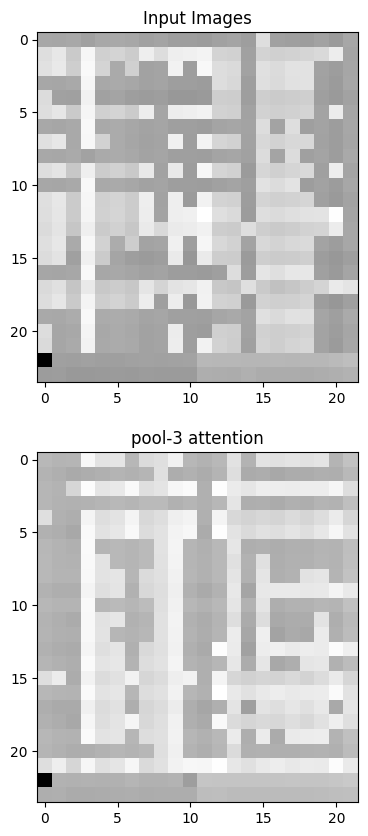

In [11]:
import torchvision
#import cv2
def visualize_attention(I_train,a,no_attention=False):

    img = I_train.permute((1,2,0)).cpu().numpy()
    # compute the heatmap
    attn = torchvision.utils.make_grid(a, nrow=8, normalize=True, scale_each=True)
    attn = attn.permute((1,2,0)).mul(255).byte().cpu().numpy()
    #attn = cv2.applyColorMap(attn, cv2.COLORMAP_JET)
    #attn = cv2.cvtColor(attn, cv2.COLOR_BGR2RGB)
    attn = np.float32(attn) / 255
    #print(attn[13])
    # add the heatmap to the image
    #img=cv2.resize(img,(466,60))
    return torch.from_numpy(attn)
    
#print(X.shape,att.shape)
ypred, att = model.forward(torch.stack(xstar[0:31]).to(device))
#print(abs(ypred-ystar[0:31]) < 1)
#print(X[3][7,-3])
orig=visualize_attention(xstar[3],att[3],no_attention=True)
first=visualize_attention(xstar[13],att[13],no_attention=False)
#second=visualize_attention(I_train,a2,up_factor=4,no_attention=False)
#one = torch.ones_like(first)
fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(10, 10))
ax1.imshow(first)
ax2.imshow(orig
           )
#ax3.imshow(second)
ax1.title.set_text('Input Images')
ax2.title.set_text('pool-3 attention')
#ax3.title.set_text('pool-4 attention')

In [10]:
torch.save(model.state_dict(), 'modelSkynet34-2.pt')
torch.save(optimizer.state_dict(), 'optimSkynet34-2.pt')


In [23]:
#model = torch.load("modelgood.pt")
model = Skynet3().to(device)
model.load_state_dict(torch.load("modelSkynet33-2.pt"))
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
optimizer.load_state_dict(torch.load("optimSkynet33-2.pt"))
#model.eval()

In [25]:
sumnet = 0
lossnet = 0
out = []
X = []
Y = []
j = 0
yin = []
fstate = []
for x, y, s in zip(xtest,ytest,teststate):
		fstate += [s[2]]
		y = torch.tensor(y)
		yin += [y]
		if s[2] > 0:
			if j >= 127:
				j = 0
				X += [x]
				Y += [y]
				# send the input to the device
				X = torch.stack(X).to(device)
				Y = torch.Tensor(Y).to(device)
				#print(nn.ReLU(x))
				ystar, att = model.forward(X)
				ystar = torch.squeeze(ystar.detach())
				#print(ystar)
				#print(ystar)
				# perform a forward pass and calculate the training loss
			#pred = model(x)
				#print(x)
				#print(ystar,np.atleast_2d(y))
				#print(ystar.shape, Y.shape)
				#loss = lossfunc1(ystar, Y)
				#print(loss)
				# zero out the gradients, perform the backpropagation step,
				# and update the weights
			# add the loss to the total training loss so far and
			# calculate the number of correct predictions
				lossnet += sum(abs(ystar - Y))
				X = []

				#print(sum((abs(ystar - Y) <= 1)))
				#print(ystar.shape, Y.shape)
				#print(ystar.shape,Y.shape)
				#print()
				#print((abs(ystar - Y) <= 1))
				sumnet += sum(abs(ystar - Y) <= 1)
				#losssum += sum(abs(ystar - Y))
				Y = []
				if out == []:
					out = ystar
				else:
					out = torch.cat((out,ystar),dim = 0)
				#print(len(out))

			#print(ystar,y)
			else:
				j += 1
				X += [x]
				Y += [y]

j = 0

X = torch.stack(X).to(device)
Y = torch.Tensor(Y).to(device)
			#print(nn.ReLU(x))
ystar, att = model.forward(X)
ystar = torch.squeeze(ystar.detach())
			#print(ystar)
			#print(ystar)
			# perform a forward pass and calculate the training loss
		#pred = model(x)
			#print(x)
			#print(ystar,np.atleast_2d(y))
			#print(ystar.shape, Y.shape)
			#loss = lossfunc1(ystar, Y)
			#print(loss)
			# zero out the gradients, perform the backpropagation step,
			# and update the weights
		# add the loss to the total training loss so far and
		# calculate the number of correct predictions
lossnet += sum(abs(ystar - Y))

			#print(sum((abs(ystar - Y) <= 1)))
			#print(ystar.shape, Y.shape)
			#print(ystar.shape,Y.shape)
			#print()
			#print((abs(ystar - Y) <= 1))
sumnet += sum(abs(ystar - Y) <= 1)
			#losssum += sum(abs(ystar - Y))
			

out = torch.cat((out,ystar),dim = 0)
	

print(lossnet/len(out), sumnet/len(out))

tensor(1.2716, device='cuda:0') tensor(0.8207, device='cuda:0')


In [28]:
print(len(X))

122


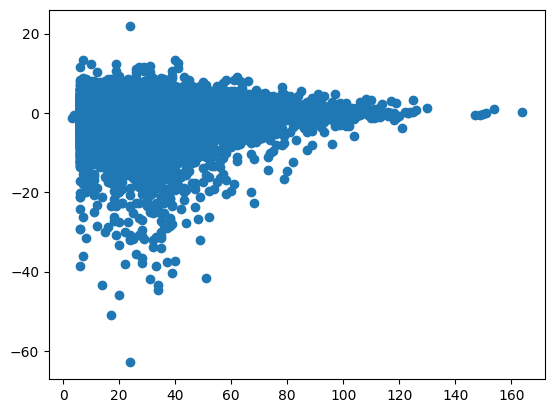

In [19]:
plt.scatter(fstate,out.to('cpu') - torch.tensor(yin))